<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/GLSL_%2B_NCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install moderngl
!git clone https://github.com/moderngl/moderngl
!pip install -r moderngl/examples/requirements.txt

# set up

In [1]:
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))
  
  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-ff6babc8-18e1-753b-2f23-72d790fb6dd0)


In [3]:
import torch 
import torchvision.models as models

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
lap = torch.tensor([[1.,2.,1.], [2., -12., 2.], [1., 2., 1.]])

CHN = 12

In [5]:
class CA(torch.nn.Module):

    def __init__(self):
        super().__init__()

        filters = torch.stack([lap, sobel_x, sobel_x.T])
        self.filters = filters.repeat(CHN//len(filters), 1, 1)[:,None]

        self.w = torch.nn.Parameter(torch.randn(CHN, CHN*4, 1, 1) * 1e-3)
        self.b = torch.nn.Parameter(torch.zeros(CHN))


    def forward(self, x, update_rate=.5):
        y = torch.nn.functional.pad(x, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, self.filters, groups=y.shape[1])
        y = torch.cat([x, y], 1)
        y = torch.cat([y, y.abs()], 1)
        y = torch.nn.functional.conv2d(y, self.w, self.b)
        update_mask = (torch.rand(*y.shape) + update_rate).floor()
        return x+y*update_mask

    def seed(self, n, sz=128):
        return torch.zeros(n, CHN, sz, sz)

    def to_rgb(x):
        return x[..., :3, :, :] + .5

ca = CA()

print('param count: ', sum(p.numel() for p in ca.parameters()))


param count:  588


In [6]:
vgg16 = models.vgg16(pretrained=True).features

def calc_styles(imgs):
  style_layers = [1, 6, 11, 18, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  grams = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def style_loss(grams_x, grams_y):
  loss = 0.0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()
  return loss

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)



In [73]:
with open('/content/compute.gl', 'w') as f:
    f.write("""
// %%VARIABLE%% will be replaced with consts by python code
// author: minu jeong

#version 430

#define X %%X%%
#define Y %%Y%%
#define Z %%Z%%
#define W %%W%%
#define H %%H%%

layout(local_size_x=X, local_size_y=Y, local_size_z=Z) in;
layout (std430, binding=0) buffer in_0
{
    vec4 inxs[1];
};

layout (std430, binding=1) buffer out_0
{
    vec4 outxs[1];
};

layout (std430, binding=2) buffer uv_0
{
    vec2 uvs[1];
};

#define win_width 5
#define win_height 5
#define win_wh 25
vec4 window[win_wh] = {
    // should manually initialize this
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0)
};

void main()
{
    // define consts
    const int x = int(gl_LocalInvocationID.x);
    const int y = int(gl_WorkGroupID.x);
    const int frag_i = x + y * W;

    int ignored = 0;
    // read window
    for (int win_x = 0; win_x < win_width; win_x++)
    {
        for (int win_y = 0; win_y < win_height; win_y++)
        {
            int win_i = win_y * win_width + win_x;
            int wox = win_x - win_width / 2;
            int woy = win_y - win_height / 2;
            int src_i = x + wox + (y + woy) * W;
            if (src_i < 0 || src_i > W * H)
            {
                window[win_i] = vec4(0, 0, 0, 0);
                ignored++;
                continue;
            }

            window[win_i] = inxs[src_i];
        }
    }

    // simple bubble sort to find median
    while(true)
    {
        bool is_swapped = false;
        for (int win_ii = win_wh - 1; win_ii > 1; win_ii--)
        {
            vec4 now = window[win_ii];
            if (now.w == 0.0) { continue; }
            if (length(window[win_ii - 1]) > length(now))
            {
                // swap
                window[win_ii] = window[win_ii - 1];
                window[win_ii - 1] = now;
                is_swapped = true;
            }
        }

        if (!is_swapped)
        {
            break;
        }
    }
    int median_i = win_wh / 2 + ignored / 2;
    vec4 median = window[median_i];

    // write to buffer
    outxs[frag_i] = vec4(median.xyz, 1.0);
    // outxs[frag_i] = vec4(1., 0., 1., 1.);
}
"""
    )

In [74]:
import os

import moderngl
import numpy as np
import imageio  # for output

from IPython.display import clear_output


# export DISPLAY=:0
os.environ['DISPLAY'] = ':0'

def source(uri, consts):
    ''' read gl code '''
    with open(uri, 'r') as fp:
        content = fp.read()

    # feed constant values
    for key, value in consts.items():
        content = content.replace(f"%%{key}%%", str(value))
    return content


# W = X * Y  // for each run, handles a row of pixels
# execute compute shader for H times to complete
W = 128
H = 128
X = W
Y = 1
Z = 1
consts = {
    "W": W,
    "H": H,
    "X": X + 1,
    "Y": Y,
    "Z": Z,
}

FRAMES = 128
OUTPUT_DIRPATH = '/content/output'
!mkdir /content/output/

if not os.path.isdir(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

glsl_file = os.path.join('/content/compute.gl')
# context = moderngl.create_standalone_context(require=430)
context = moderngl.create_context(require=430, standalone=True, backend='egl')
compute_shader = context.compute_shader(source(glsl_file, consts))

# init buffers
buffer_a_data = np.random.uniform(0.0, 1.0, (H, W, 4)).astype('f4')
buffer_a = context.buffer(buffer_a_data)
buffer_b_data = np.zeros((H, W, 4)).astype('f4')
buffer_b = context.buffer(buffer_b_data)

imgs = []
last_buffer = buffer_b
for i in range(FRAMES):
    toggle = True if i % 2 else False
    buffer_a.bind_to_storage_buffer(1 if toggle else 0)
    buffer_b.bind_to_storage_buffer(0 if toggle else 1)

    # toggle 2 buffers as input and output
    last_buffer = buffer_a if toggle else buffer_b

    # local invocation id x -> pixel x
    # work groupid x -> pixel y
    # eg) buffer[x, y] = gl_LocalInvocationID.x + gl_WorkGroupID.x * W
    compute_shader.run(group_x=H, group_y=1)

    # print out
    output = np.frombuffer(last_buffer.read(), dtype=np.float32)
    output = output.reshape((H, W, 4))
    output = np.multiply(output, 255).astype(np.uint8)
    imgs.append(output)

# if you don't want to use imageio, remove this section
out_path = f"{OUTPUT_DIRPATH}/train.gif"
print("Writing GIF anim to", out_path)
imageio.mimwrite(out_path, imgs, "GIF", duration=0.15)

train_imgs = imgs


mkdir: cannot create directory ‘/content/output/’: File exists
Writing GIF anim to /content/output/train.gif


In [38]:
imageio.imwrite('/content/output/start.png', imgs[0])

# train

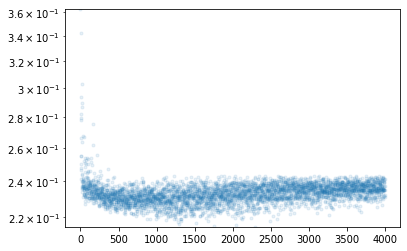

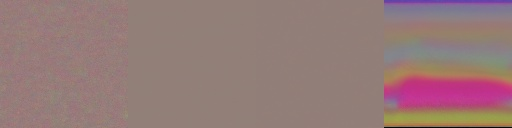

step_n: 4041  loss: 0.23697936534881592  lr: 8.999999999999999e-05

KeyboardInterrupt: ignored

In [69]:

def to_rgb(x):
  # Modified: make starting state black
  return x[...,:3,:,:] #+0.5


ca = CA()
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 4000, 6000], .3)
loss_lor = []


def calc_loss(x, target):
    return (x - target).abs().mean()

targets = torch.as_tensor(train_imgs, dtype=torch.float32) / 255


with torch.no_grad():
    pool = ca.seed(256)
    pool[:, :3, :, :] = torch.moveaxis(targets[0][..., :3], -1, 0)

loss_log = []
for i in range(8000):

    step_n = np.random.randint(32, 64)

    with torch.no_grad():
        batch_idx = np.random.choice(len(pool), 4, replace=False)
        x = pool[batch_idx]
        if i%8 == 0:
            x[:1] = ca.seed(1)

    for k in range(step_n):
        x = ca(x)
    imgs = to_rgb(x)

    target = torch.moveaxis(targets[step_n][...,:3], -1, 0)


    loss = calc_loss(imgs, target)
    total_loss = loss

    with torch.no_grad():
        total_loss.backward()
        for p in ca.parameters():
            p.grad /= (p.grad.norm()+1e-8)
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        pool[batch_idx] = x
        loss_log.append(loss.item())
        # print(loss.item())

        if i%100==0:
            clear_output(True)
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.show()
            imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
            imshow(np.hstack(imgs))
        if i%10 == 0:
            print('\rstep_n:', len(loss_log),
                    ' loss:', loss.item(), 
                    ' lr:', lr_sched.get_lr()[0], end='')
        if len(loss_log) % 500 == 0:
            torch.save(ca, 'ca_%05d.pt'%len(loss_log))


In [70]:
with VideoWriter('ca.mp4') as vid, torch.no_grad():
  x = ca.seed(1, 128)
  x[:,:3, :, :] = torch.moveaxis(targets[0][..., :3], -1, 0)
  for k in range(100):
    step_n = min(2**(k//30), 32)
    for i in range(step_n):
      x[:] = ca(x)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    im = np.hstack([img, train_imgs[k][...,:3] / 255])
    vid.add(zoom(im, 2))
vid.show()